In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=30, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=5e-05, n_cpu=8, n_critic=5, n_epochs=30, sample_interval=400)


In [3]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [6]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [7]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

In [8]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [9]:
# ----------
#  Training
# ----------
LD = []
LG = []
x = []
batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        # Train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()
            if (i % len(dataloader))%300==0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (
                        epoch, opt.n_epochs, i % len(dataloader), len(dataloader), loss_D.item(),
                        loss_G.item())
                )
        batches_done += 1
    save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)

    LD.append(loss_D.item())
    LG.append(loss_G.item())
    x.append(epoch + 1)



[Epoch 0/30] [Batch 0/938] [D loss: -0.107439] [G loss: -0.012355]
[Epoch 0/30] [Batch 300/938] [D loss: -4.849861] [G loss: -20.476517]
[Epoch 0/30] [Batch 600/938] [D loss: -0.978977] [G loss: -18.477661]
[Epoch 0/30] [Batch 900/938] [D loss: -0.590790] [G loss: -15.597271]
[Epoch 1/30] [Batch 0/938] [D loss: -0.823355] [G loss: -15.316521]
[Epoch 1/30] [Batch 300/938] [D loss: -0.288311] [G loss: -14.070800]
[Epoch 1/30] [Batch 600/938] [D loss: -0.127595] [G loss: -14.277700]
[Epoch 1/30] [Batch 900/938] [D loss: -0.093527] [G loss: -11.533291]
[Epoch 2/30] [Batch 0/938] [D loss: -0.030598] [G loss: -11.279726]
[Epoch 2/30] [Batch 300/938] [D loss: -0.246073] [G loss: -13.301340]
[Epoch 2/30] [Batch 600/938] [D loss: -0.021298] [G loss: -8.617203]
[Epoch 2/30] [Batch 900/938] [D loss: -0.080900] [G loss: -4.105180]
[Epoch 3/30] [Batch 0/938] [D loss: -0.048580] [G loss: -2.321587]
[Epoch 3/30] [Batch 300/938] [D loss: -0.045290] [G loss: -0.202013]
[Epoch 3/30] [Batch 600/938] [D l

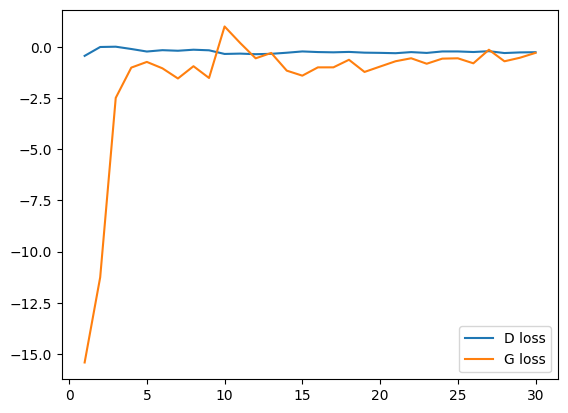

In [11]:
plt.plot(x, LD, label='D loss')
plt.plot(x, LG, label='G loss')
plt.legend()
plt.savefig('./test.png')
plt.show()

In [12]:
import zipfile
import os

def zip_folder(folder_path, zip_filename):
    # 创建一个Zip文件对象
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # 遍历文件夹内的所有文件并添加到Zip文件
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# 调用函数，压缩文件夹
folder_to_compress = 'images'  # 替换为你的文件夹路径
zip_filename = 'images.zip'  # 替换为你的压缩文件名

zip_folder(folder_to_compress, zip_filename)